*This Notebook has been created by PALISSON Antoine.*<br>


In [ ]:
# Base packages import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Datasets

pmdarima datasets [Documentation](https://alkaline-ml.com/pmdarima/modules/classes.html#pmdarima-datasets-toy-timeseries-datasets)<br>

In [ ]:
# You need to re-install statsmodel before installing pmdarima on google colab
# On your local machine, be careful on the versions you are using
!pip install -q statsmodels
!pip install -q pmdarima
from pmdarima.datasets import load_airpassengers, load_msft, load_ausbeer, load_austres

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 93.9 MB/s eta 0:00:00


In [ ]:
airp_df = load_airpassengers(as_series=True)
airp_df.index = pd.to_datetime(pd.date_range(start='01/01/1949', periods=len(airp_df), freq='M'))
airp_df.name = 'Air Passenger'

msft_df = load_msft()
msft_df = pd.Series(msft_df['Close'].to_numpy(), index=msft_df['Date'])
msft_df.index = pd.to_datetime(msft_df.index)

# Simple RNN

Simple RNN layers can be used whenever a Time Series does not require the model to remember information from long ago.

In TensorFlow Keras, the SimpleRNN layer has several important parameters that you can use to configure the behavior of the layer. Some of the most important parameters include:

* **units**: This parameter specifies the number of hidden units in the SimpleRNN layer. The number of hidden units determines the size of the internal representation of the input data, and can affect the model's ability to capture complex patterns in the data. High values may harm the performances for simple datasets whereas low values may harm the performances for complex datasets.

* **activation**: This parameter specifies the activation function to use for the output of the SimpleRNN layer. Common activation functions include "relu", "tanh", and "sigmoid". In general, it's a good idea to try different activation functions and compare the performance of the model to see which one works best.

* **return_sequences**: This parameter determines whether the output of the SimpleRNN layer should be returned for every timestep or just the last timestep. If set to True, the output will be returned for every timestep, and can be used as input to another RNN layer. If set to False, the output will only be returned for the last timestep, and is typically used as input to a dense layer.

* **return_state**: This parameter determines whether the hidden state of the SimpleRNN layer should be returned. If set to True, the hidden state will be returned in addition to the output, and can be used to initialize the state of another RNN layer. If set to False, the hidden state will not be returned.

* **input_shape**: This parameter specifies the shape of the input data, in the form of (batch_size, timesteps, input_dim). It is only required when creating the first layer of the model.

* **kernel_initializer** and recurrent_initializer : These parameters are used to initialize the weight matrices of the SimpleRNN layer. You can use different initializers to change the behavior of the model and to improve the training performance.

* **kernel_regularizer** and **recurrent_regularizer**: These parameters are used to apply weight regularization to the SimpleRNN layer. Regularization can help prevent overfitting by adding a penalty term to the loss function based on the magnitude of the weights.

* **dropout**: This parameter applies dropout regularization to the output of the SimpleRNN layer. Dropout randomly sets a fraction of the input units to 0 at each update during training time, which helps prevent overfitting by reducing the number of parameters that can be updated.

In general, a deeper model (more layers) can potentially capture more complex patterns in the data, but it can also increase the risk of overfitting. On the other hand, a shallower model (fewer layers) may not be able to capture as many complex patterns, but it may be less prone to overfitting.

A good way to decide the number of layers is to start with a small number of layers and gradually increase the number while monitoring the performance of the model on a validation set. You can also try to use early stopping, which is a technique that can help you decide when to stop training by monitoring the performance on a validation set.

SimpleRNN

```
# Ce texte est au format code
```

 [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)

## One step at a time

In this exercise, we will predict the next value based and the previous ones.

**1. Split the airp_df time series into a train and a test set without shuffling.**

*Tips: We will create the validation set later on.*

In [ ]:
from sklearn.model_selection import train_test_split
airp_train, airp_test = train_test_split(airp_df, test_size=0.2, shuffle=False)

The input shape of a SimpleRNN model in TensorFlow Keras is a tuple of three integers that specify the dimensions of the input data, in the form of (batch_size, timesteps, input_dim).

* **batch_size**: This is the number of samples per gradient update. It corresponds to the number of samples in a batch. For example, if you have 1000 samples and a batch size of 32, it will take 32 gradient updates to process all of the samples.

* **timesteps**: This is the number of time steps in the input data. In the case of time series data, the timesteps represent the number of observations of the time series at a specific time interval. The number of time steps is also related to the length of the sequence you want to process.

* **input_dim**: This is the number of features in the input data. It corresponds to the number of input dimensions in the input data. For example, if you are processing text data, it corresponds to the number of unique words in the vocabulary.

For example, if you are working with a window size of 12 for a Time Series without any exogenous variable, the shape of the X dataset should be set to (Batch Size, 12, 1). Additionally, if you want to predict the next value, the Y dataset should be set to (Batch Size, 1).

`[____XXXXXY______]`<br>
`[_____XXXXXY_____]`<br>
`[______XXXXXY____]`<br>
`[_______XXXXXY___]`<br>

**2. Create the feature (X) set by using a sliding windows of size 12, with a step of 1 for both train and test sets. Create the label (Y) set by using the next value i.e. the one after the window.**

In [ ]:
def create_windows(data, win_length,win_offset,target_length):
    X = []
    y = []

    max_length = len(data) - win_length - target_length  + 1
    for i in range(0, max_length, win_offset):
        X.append(data[i:i+win_length])
        y.append(data[i+win_length:i+win_length+target_length])
    
    return np.array(X)[..., np.newaxis], np.array(y)

In [ ]:
win_length = 12
win_offset = 1
target_length = 1

X_train, y_train = create_windows(airp_train, 
                                  win_length = win_length,
                                  win_offset = win_offset,
                                  target_length = target_length)

X_test, y_test = create_windows(airp_test, 
                                win_length = win_length,
                                win_offset = win_offset,
                                target_length = target_length)

**3. Standardize the values of the Time Series.**

*Tips: Don't forget to only compute the calculations on the Train set but apply the standardization to every set.*

In [ ]:
mu = X_train.mean()
si = X_train.std()

In [ ]:
X_train_std = (X_train - mu)/si
y_train_std = (y_train - mu)/si

X_test_std = (X_test - mu)/si
y_test_std = (y_test - mu)/si

There are many ways to create a simple RNN Deep Learning model architecture using **`Tensorflow Keras`**. Here is one of the simplest method:



1.   Start by creating the model with the `tf.keras.Sequential()` class
2.   Add the `Input()` layer to the model with the `model.add()` method. The input layer should contain the shape of the training data (window_length, number of features)
3.   Add one `SimpleRNN()`. Don't forget to specify its hyperparameters.
4.   Add more layers. If you are stacking SimpleRNN layers, don't forget to turn the `return_sequences` parameter to True unless it is the last SimpleRNN before the output layer.
5.   Add the output layer. For a Time Series, it is generally a `Dense()` layers that does not have any activation. The number of units depends on the number of outputs needed.

Sequential [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)<br>
Dense [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)


**4.a. Define a sequential deep learning model architecture that contains one input layer, some SimpleRNN layers and one output layer.<br> 4.b. Show the architecture and the parameters of the model using the `model.summary()` method.**

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Create a sequential model
model = tf.keras.models.Sequential()

# Add the input layer
model.add(tf.keras.layers.Input(shape=(win_length, 1)))

# Add the recurrent layer
model.add(tf.keras.layers.SimpleRNN(units=20, activation ='tanh', return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(units=20, activation ='tanh', return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(units=20))

# Output layer
model.add(tf.keras.layers.Dense(units=1, activation=None))

# Print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12, 20)            440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 12, 20)            820       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In TensorFlow, the `compile()` method is used to configure the learning process before training a model. It is typically called after the model architecture has been defined and the model has been compiled with the optimizer, loss function, and metrics to be used during training. The `compile()` method takes several arguments such as optimizer, loss and metrics. These are used to configure the model's training process.

Adam Optimizer [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)<br>
MSE loss [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError)

**5. Compile the model by adding an optimizer, a loss and, optionally, a metric using the `model.compile()` method. <br>Set the learning_rate of the optimizer to 0.001**

*Tips: You can use the Adam optimizer and the mean squared error loss.*

In [ ]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse')

The `fit()` function is used to train a model. It is typically called after the model architecture has been defined and the model has been compiled with the optimizer, loss function, and metrics to be used during training. 

It returns a history object that contains the loss and metric values for each epoch of training.

The fit() method in TensorFlow has several important parameters, including:

* **x**: This is the input data for the model, typically a numpy array or a dataset.
* **y**: This is the target data for the model, also typically a numpy array or a dataset. It contains the labels or values that the model should predict.
* **batch_size**: This is the number of samples to use in each iteration of training. The model will update its weights after every batch.
* **epochs**: This is the number of times the model will iterate over the entire dataset during training.
* **validation_data** : This is used to monitor the training process, it can be a tuple of x and y validation data.
* **validation_split** : This is used to monitor the training process, it is the ratio of the data that will be used as a validation set.
* **verbose**: This is used to control how much output is printed during training. A value of 0 means no output is printed, while a value of 1 means progress bars and updates are printed.

Other paramters exist. You can check the `fit()` [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

**6. Train the model by using the `model.fit()` method.<br>Specify a value for the number of `epochs` and the `batch_size`, and set the validation_split hyperparameter to 0.1**

*Tips: You can use an early stopping callback to avoir overfitting.*

In [ ]:
# This is a callback to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_std, y_train_std,
                    validation_split=0.1,
                    epochs = 50,
                    batch_size=4,
                    callbacks=[early])

Epoch 1/50
23/23 [==============================] - 2s 34ms/step - loss: 0.2810 - val_loss: 0.4120
Epoch 2/50
23/23 [==============================] - 0s 19ms/step - loss: 0.1543 - val_loss: 0.3342
Epoch 3/50
23/23 [==============================] - 0s 19ms/step - loss: 0.1016 - val_loss: 0.2857
Epoch 4/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0803 - val_loss: 0.2473
Epoch 5/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0598 - val_loss: 0.2117
Epoch 6/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0487 - val_loss: 0.1788
Epoch 7/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0428 - val_loss: 0.1743
Epoch 8/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0414 - val_loss: 0.1596
Epoch 9/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0403 - val_loss: 0.1235
Epoch 10/50
23/23 [==============================] - 0s 19ms/step - loss: 0.0347 - val_loss: 0.1189
Epoch 11/

In TensorFlow, the `predict()` method is used to generate predictions for new data using a trained model. It is typically called after the model has been trained using the `fit()` method. 

The `predict()` method takes one or more input data and returns the model's predictions for each input. The input data should be in the same format as the input data used during training.

predict() [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict) 

**7.a. Predict the test set using the `model.predict()`.<br>7.b. Plot the predictions on a graph along with the true data.<br>7.c. Compute the RMSE.**

In [ ]:
y_pred = model.predict(X_test_std)

1/1 [==============================] - 0s 292ms/step


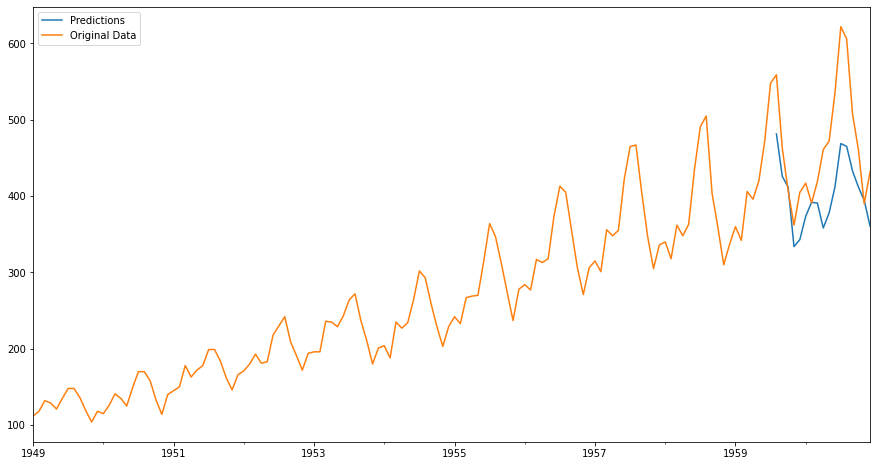

In [ ]:
# Inverse the Standard Scaler transformation
inv_pred = (y_pred*si + mu).ravel()

# Create a Pandas Series to plot the results
pd.Series(inv_pred, 
          index= airp_test[win_length:].index).plot(figsize=(15,8), label='Predictions')

# Plot the original data
airp_df.plot(figsize=(15,8), label='Original Data')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((inv_pred - y_test.ravel())**2))
print(f"RMSE : {rmse:.2f}")

RMSE : 78.83


## Multiple steps at a time

In this exercise, we will predict the next n-th values based and the previous ones.

Evertyhing is similar to the previous exercise but the the window creation is changed as follows:

`[____XXXXXYYY____]`<br>
`[_____XXXXXYYY___]`<br>
`[______XXXXXYYY__]`<br>
`[_______XXXXXYYY_]`<br>

Additionally, the output layer should now contain n-th units: one for each value we want to forecast.

**Do the same as the previous exercise.**

In [ ]:
# Create the windows

win_length = 12
win_offset = 1
target_length = 12

X_train, y_train = create_windows(airp_train, 
                                  win_length = win_length,
                                  win_offset = win_offset,
                                  target_length = target_length)

X_test, y_test = create_windows(airp_test, 
                                win_length = win_length,
                                win_offset = win_offset,
                                target_length = target_length)

In [ ]:
# Standardize the data

mu = X_train.mean()
si = X_train.std()

X_train_std = (X_train - mu)/si
y_train_std = (y_train - mu)/si

X_test_std = (X_test - mu)/si

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Create a sequential model
model = tf.keras.models.Sequential()

# Add the input layer
model.add(tf.keras.layers.Input(shape=(win_length, 1)))

# Add the recurrent layer
model.add(tf.keras.layers.SimpleRNN(units=20, activation='relu', return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(units=20, activation='relu', return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(units=20, activation='relu'))

# Add the output layer with target_length units
model.add(tf.keras.layers.Dense(units=target_length, activation=None))

# Print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12, 20)            440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 12, 20)            820       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
Total params: 2,332
Trainable params: 2,332
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse')

In [ ]:
# This is a callback to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_std, y_train_std,
                    validation_split=0.1,
                    epochs = 50,
                    batch_size=4,
                    callbacks=[early])

Epoch 1/50
21/21 [==============================] - 3s 41ms/step - loss: 0.9583 - val_loss: 4.3819
Epoch 2/50
21/21 [==============================] - 1s 25ms/step - loss: 0.8389 - val_loss: 3.6143
Epoch 3/50
21/21 [==============================] - 1s 25ms/step - loss: 0.5963 - val_loss: 1.9064
Epoch 4/50
21/21 [==============================] - 1s 25ms/step - loss: 0.3485 - val_loss: 1.0512
Epoch 5/50
21/21 [==============================] - 1s 26ms/step - loss: 0.2580 - val_loss: 0.8602
Epoch 6/50
21/21 [==============================] - 1s 28ms/step - loss: 0.2258 - val_loss: 0.7743
Epoch 7/50
21/21 [==============================] - 1s 27ms/step - loss: 0.2074 - val_loss: 0.7383
Epoch 8/50
21/21 [==============================] - 1s 27ms/step - loss: 0.2027 - val_loss: 0.7809
Epoch 9/50
21/21 [==============================] - 1s 27ms/step - loss: 0.1993 - val_loss: 0.6636
Epoch 10/50
21/21 [==============================] - 1s 27ms/step - loss: 0.1916 - val_loss: 0.6814
Epoch 11/

1/1 [==============================] - 0s 22ms/step


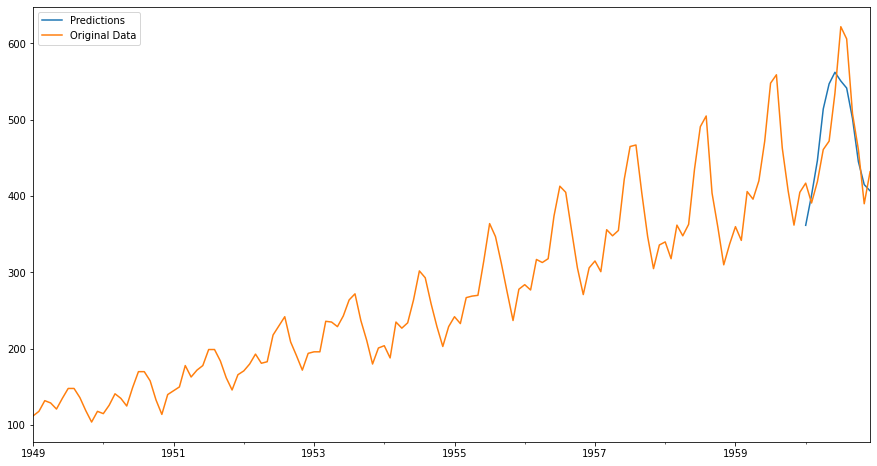

In [ ]:
# Get the preds, transform them and plot them
y_pred = model.predict(X_test_std)
inv_pred = (y_pred*si + mu)

pd.Series(inv_pred[-1].ravel(), 
          index= airp_df[-target_length:].index).plot(figsize=(15,8), label='Predictions')

airp_df.plot(figsize=(15,8), label='Original Data')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((inv_pred.ravel() - y_test.ravel())**2))
print(f"RMSE : {rmse:.2f}")

RMSE : 37.04


# Bidirectionnal RNN

In this exercise, we will use the bidirectional RNN.

The `Bidirectional()` class is a wrapper layer that applies a recurrent layer to the input in both directions, processing the input forwards and backwards to get a full representation of the input sequence. The most important parameters of this class are:

* **layer**: This is the recurrent layer instance to be wrapped. The layer should have a stateful=False.
* **merge_mode**: This parameter controls how the forward and backward outputs are combined. There are four options: 'concat', 'sum', 'ave', 'mul'
* **weights**: List of Numpy arrays to set as initial weights. The list should have 2 elements, of shape (input_dim, output_dim) and (output_dim,) for weights and biases respectively.
* **backward_layer** : Instance of the recurrent layer to be used for the backward pass. If not provided, it will be created by cloning the layer.

You can directly pass this layer around the `SimpleRNN` layer during the model architecture creation.

`Bidirectional` [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

## One step at a time


**Follow the same guidelines as the first exercise.**

In [ ]:
# Create the windows

win_length = 12
win_offset = 1
target_length = 1

X_train, y_train = create_windows(airp_train, 
                                  win_length = win_length,
                                  win_offset = win_offset,
                                  target_length = target_length)

X_test, y_test = create_windows(airp_test, 
                                win_length = win_length,
                                win_offset = win_offset,
                                target_length = target_length)

In [ ]:
# Standardize the data

mu = X_train.mean()
si = X_train.std()

X_train_std = (X_train - mu)/si
y_train_std = (y_train - mu)/si

X_test_std = (X_test - mu)/si

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Create a sequential model
model = tf.keras.models.Sequential()

# Add the input layer
model.add(tf.keras.layers.Input(shape=(win_length, 1)))

# Add the bidirectional recurrent layers
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=20, activation='relu', return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=20, activation='relu', return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=20, activation='relu')))

# Add the output layer
model.add(tf.keras.layers.Dense(units=target_length, activation=None))

# Print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 12, 40)           880       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 12, 40)           2440      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               2440      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 5,801
Trainable params: 5,801
Non-trainable params: 0
______________________________________________________

In [ ]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse')

In [ ]:
# This is a callback to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_std, y_train_std,
                    validation_split=0.1,
                    epochs = 50,
                    batch_size=4,
                    callbacks=[early])

Epoch 1/50
23/23 [==============================] - 5s 66ms/step - loss: 0.3906 - val_loss: 0.6742
Epoch 2/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0963 - val_loss: 0.3166
Epoch 3/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0659 - val_loss: 0.2294
Epoch 4/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0588 - val_loss: 0.0982
Epoch 5/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0407 - val_loss: 0.0682
Epoch 6/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0312 - val_loss: 0.1026
Epoch 7/50
23/23 [==============================] - 1s 37ms/step - loss: 0.0282 - val_loss: 0.0340
Epoch 8/50
23/23 [==============================] - 1s 37ms/step - loss: 0.0294 - val_loss: 0.0322
Epoch 9/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0199 - val_loss: 0.0352
Epoch 10/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0161 - val_loss: 0.0535
Epoch 11/

In [ ]:
y_pred = model.predict(X_test_std)

1/1 [==============================] - 1s 584ms/step


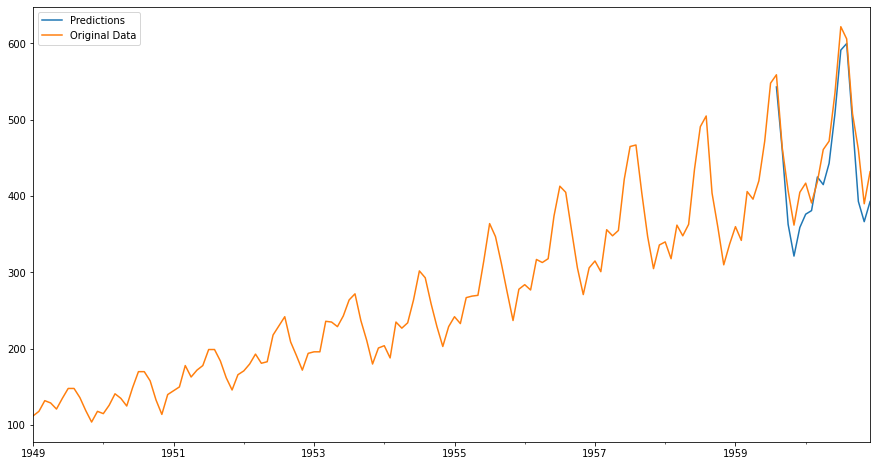

In [ ]:
# Inverse the Standard Scaler transformation
inv_pred = (y_pred*si + mu).ravel()

# Create a Pandas Series to plot the results
pd.Series(inv_pred, 
          index= airp_test[win_length:].index).plot(figsize=(15,8), label='Predictions')

# Plot the original data
airp_df.plot(figsize=(15,8), label='Original Data')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((inv_pred - y_test.ravel())**2))
print(f"RMSE : {rmse:.2f}")

RMSE : 33.64


## Multiple steps at a time

**Follow the same guidelines as the second exercise with a Bidirectional method.**

In [ ]:
# Create the windows

win_length = 12
win_offset = 1
target_length = 12

X_train, y_train = create_windows(airp_train, 
                                  win_length = win_length,
                                  win_offset = win_offset,
                                  target_length = target_length)

X_test, y_test = create_windows(airp_test, 
                                win_length = win_length,
                                win_offset = win_offset,
                                target_length = target_length)

In [ ]:
# Standardize the data

mu = X_train.mean()
si = X_train.std()

X_train_std = (X_train - mu)/si
y_train_std = (y_train - mu)/si

X_test_std = (X_test - mu)/si

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Create a sequential model
model = tf.keras.models.Sequential()

# Add the input layer
model.add(tf.keras.layers.Input(shape=(win_length, 1)))

# Add the bidirectional recurrent layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=20, activation='relu', return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=20, activation='relu', return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=20, activation='relu')))

# Add the output layer
model.add(tf.keras.layers.Dense(units=target_length, activation=None))

# Print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 12, 40)           880       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 12, 40)           2440      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               2440      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 12)                492       
                                                                 
Total params: 6,252
Trainable params: 6,252
Non-trainable params: 0
______________________________________________________

In [ ]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse')

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_std, y_train_std,
                    validation_split=0.1,
                    epochs = 50,
                    batch_size=4,
                    callbacks=[early])

Epoch 1/50
21/21 [==============================] - 5s 79ms/step - loss: 0.9285 - val_loss: 4.3647
Epoch 2/50
21/21 [==============================] - 1s 49ms/step - loss: 0.6749 - val_loss: 2.5530
Epoch 3/50
21/21 [==============================] - 1s 50ms/step - loss: 0.3988 - val_loss: 1.4019
Epoch 4/50
21/21 [==============================] - 1s 47ms/step - loss: 0.2572 - val_loss: 0.8513
Epoch 5/50
21/21 [==============================] - 1s 47ms/step - loss: 0.1927 - val_loss: 0.7153
Epoch 6/50
21/21 [==============================] - 1s 46ms/step - loss: 0.1712 - val_loss: 0.5836
Epoch 7/50
21/21 [==============================] - 1s 48ms/step - loss: 0.1585 - val_loss: 0.5881
Epoch 8/50
21/21 [==============================] - 1s 48ms/step - loss: 0.1496 - val_loss: 0.5788
Epoch 9/50
21/21 [==============================] - 1s 45ms/step - loss: 0.1351 - val_loss: 0.5231
Epoch 10/50
21/21 [==============================] - 1s 47ms/step - loss: 0.1337 - val_loss: 0.4475
Epoch 11/

In [ ]:
y_pred = model.predict(X_test_std)

1/1 [==============================] - 1s 573ms/step


1/1 [==============================] - 0s 30ms/step


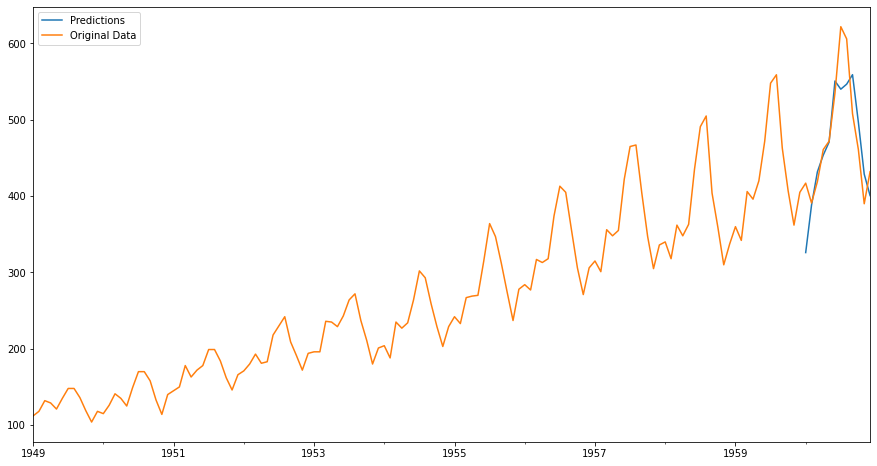

In [ ]:
# Get the preds, transform them and plot them
y_pred = model.predict(X_test_std)
inv_pred = (y_pred*si + mu)

pd.Series(inv_pred[-1].ravel(), 
          index= airp_df[-target_length:].index).plot(figsize=(15,8), label='Predictions')

airp_df.plot(figsize=(15,8), label='Original Data')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((inv_pred.ravel() - y_test.ravel())**2))
print(f"RMSE : {rmse:.2f}")

RMSE : 40.31


# LSTM

In this exercise, we'll use the `LSTM` class on the msft_df Time Series.

The most important parameters of this class are very similar to the SimpleRNN class, there are:

* **units**: This is the number of hidden units in the LSTM layer. It controls the dimensionality of the output space.
* **activation**: This is the activation function to use for the LSTM layer. Common options include 'tanh' and 'relu'.
* **recurrent_activation**: This is the activation function to use for the recurrent step. Common options include 'sigmoid' and 'hard_sigmoid'
* **return_sequences**: A boolean whether to return the last output in the output sequence, or the full sequence.
* **return_state**: A boolean whether to return the last state in addition to the output.
* **stateful** : A boolean, whether the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.

The LSTM layer is more complex than the SimpleRNN model, making it more difficult to train and more prone to errors. Additionally, it is more sensitive to the choice of hyperparameters, such as the learning rate, number of hidden units, and the number of layers.

Thus, it is not always the best option especially for very simple Time Series.

**1. Use the Close column as the main Time Series and discard the other columns. <br>Split the msft_df time series into a train and a test set without shuffling.**

In [ ]:
from sklearn.model_selection import train_test_split
msft_train, msft_test = train_test_split(msft_df, test_size=0.25, shuffle=False)

**2. Create the feature (X) set by using a sliding windows of size 20, with a step of 1 for both train and test sets.<br> Create the label (Y) set by using the next value i.e. the one after the window.**

In [ ]:
def create_windows(data, win_length,win_offset,target_length):
    X = []
    y = []

    max_length = len(data) - win_length - target_length  + 1
    for i in range(0, max_length, win_offset):
        X.append(data[i:i+win_length])
        y.append(data[i+win_length:i+win_length+target_length])
    
    return np.array(X)[..., np.newaxis], np.array(y)

In [ ]:
win_length = 20
win_offset = 1
target_length = 1

X_train, y_train = create_windows(msft_train, 
                                  win_length = win_length,
                                  win_offset = win_offset,
                                  target_length = target_length)

X_test, y_test = create_windows(msft_test, 
                                win_length = win_length,
                                win_offset = win_offset,
                                target_length = target_length)

**3. Standardize the values of the Time Series.**

*Tips: Don't forget to only compute the calculations on the Train set but apply the standardization to every set.*

In [ ]:
mu = X_train.mean()
si = X_train.std()

In [ ]:
X_train_std = (X_train - mu)/si
y_train_std = (y_train - mu)/si

X_test_std = (X_test - mu)/si

**4.a. Define a sequential deep learning model architecture that contains one input layer, some LSTM layers and one output layer.<br> 4.b. Show the architecture and the parameters of the model using the `model.summary()` method.**

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Create a sequential model
model = tf.keras.models.Sequential()

# Add the input layer
model.add(tf.keras.layers.Input(shape=(win_length, 1)))

# Add the recurrent layer
model.add(tf.keras.layers.LSTM(units=30, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=30, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=30))


# Add the output layer
model.add(tf.keras.layers.Dense(units=target_length, activation=None))

# Print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 20, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


**5. Compile the model by adding an optimizer, a loss and, optionally, a metric using the `model.compile()` method. <br>Set the learning_rate of the optimizer to 0.005**

In [ ]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse')

**6. Train the model by using the `model.fit()` method.<br>Specify a value for the number of `epochs` and the `batch_size`, and set the validation_split hyperparameter to 0.1**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_std, y_train_std,
                    validation_split=0.1,
                    epochs = 25,
                    batch_size=32,
                    callbacks=[early])

Epoch 1/25
168/168 [==============================] - 6s 14ms/step - loss: 0.0335 - val_loss: 0.0070
Epoch 2/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0053 - val_loss: 0.0165
Epoch 3/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 4/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 5/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 6/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 10/25
168/168 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.003

**7.a. Predict the test set using the `model.predict()`.<br>7.b. Plot the predictions on a graph along with the true data.<br>7.c. Compute the RMSE.**

In [ ]:
y_pred = model.predict(X_test_std)

62/62 [==============================] - 1s 3ms/step


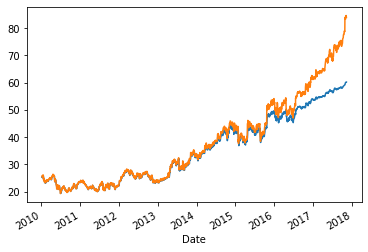

In [ ]:
# Inverse the Standard Scaler transformation
inv_pred = (y_pred*si + mu).ravel()

# Create a Pandas Series to plot the results
pd.Series(inv_pred, 
          index= msft_test[win_length:].index).plot(figsize=(15,8), label='Predictions')

# Plot the original data
msft_test[win_length:].plot(figsize=(15,8), label='Original Data')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((inv_pred.ravel() - y_test.ravel())**2))
print(f"RMSE : {rmse:.2f}")

4.956192515353867

# Exogenous features

In this last exercise, we will try to add an Exogenous feature to the msft_df Time Series.



**1. Use the Close column as the main Time Series and the Open column as an exogenous variable. <br>Split the msft_df time series into a train and a test set without shuffling.**

In [ ]:
from sklearn.model_selection import train_test_split
msft_df_f = msft_df.to_frame()
msft_df_f['Open'] = load_msft()['Open'].to_numpy()

msft_train, msft_test = train_test_split(msft_df_f, test_size=0.25, shuffle=False)

Now, the feature set contains two Time Series: the Open and the Close columns of the msft dataset.

**2. Create the feature (X) set by using a sliding windows of size 20, with a step of 1 for both train and test sets.<br> Create the label (Y) set by using the next value i.e. the one after the window.**

In [ ]:
def create_windows_exog(data, exog, win_length, win_offset, target_length):
    X = []
    X_exog = []
    y = []

    max_length = len(data) - win_length - target_length  + 1
    for i in range(0, max_length, win_offset):
        X.append(data[i:i+win_length])
        X_exog.append(exog[i:i+win_length])
        y.append(data[i+win_length:i+win_length+target_length])
    
    return np.array(X)[..., np.newaxis], np.array(X_exog)[..., np.newaxis], np.array(y)

In [ ]:
win_length = 20
win_offset = 1
target_length = 1

X_train, X_train_exog, y_train = create_windows_exog(msft_train.iloc[:,0], 
                                                     msft_train.iloc[:,1],
                                                     win_length = win_length,
                                                     win_offset = win_offset,
                                                     target_length = target_length)

X_test, X_test_exog, y_test = create_windows_exog(msft_test.iloc[:,0], 
                                                  msft_test.iloc[:,1],
                                                  win_length = win_length,
                                                  win_offset = win_offset,
                                                  target_length = target_length)

In [ ]:
X_train.shape, X_train_exog.shape

((5967, 20, 1), (5967, 20, 1))

**3. Standardize the values of the Time Series and the exogenous variable.**

*Tips: Don't forget to only compute the calculations on the Train set but apply the standardization to every set.*

In [ ]:
mu = X_train.mean()
si = X_train.std()

X_train_std = (X_train - mu)/si
y_train_std = (y_train - mu)/si

X_test_std = (X_test - mu)/si

In [ ]:
mu = X_train_exog.mean()
si = X_train_exog.std()

X_train_std_exog = (X_train_exog - mu)/si
y_train_std_exog = (X_train_exog - mu)/si

X_test_std_exog = (X_test_exog - mu)/si

In [ ]:
X_train_std_full = np.concatenate([X_train_std, X_train_std_exog],axis=-1)
X_test_std_full = np.concatenate([X_test_std, X_test_std_exog],axis=-1)

The following deep learning model should contain an input layer with a shape parameter equal to (window length, number of features).<br> In our case, it should be (20,2).

**4.a. Define a sequential deep learning model architecture that contains one input layer, some LSTM layers and one output layer.<br> 4.b. Show the architecture and the parameters of the model using the `model.summary()` method.**

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Create a sequential model
model = tf.keras.models.Sequential()

# Add the input layer
model.add(tf.keras.layers.Input(shape=(win_length, X_train_std_full.shape[-1])))

# Add the recurrent layer
model.add(tf.keras.layers.LSTM(units=30, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=30, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=30))

# Add the output layer
model.add(tf.keras.layers.Dense(units=target_length, activation=None))

# Print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 30)            3960      
                                                                 
 lstm_1 (LSTM)               (None, 20, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


**5. Compile the model, train it, predict and show the results.**

In [ ]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse')

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_std_full, y_train_std,
                    validation_split=0.1,
                    epochs = 25,
                    batch_size=32,
                    callbacks=[early])

Epoch 1/25
168/168 [==============================] - 6s 14ms/step - loss: 0.0271 - val_loss: 0.0077
Epoch 2/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0054 - val_loss: 0.0127
Epoch 3/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0040 - val_loss: 0.0061
Epoch 4/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 5/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 7/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 9/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 10/25
168/168 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.004

In [ ]:
y_pred = model.predict(X_test_std_full)

62/62 [==============================] - 1s 3ms/step


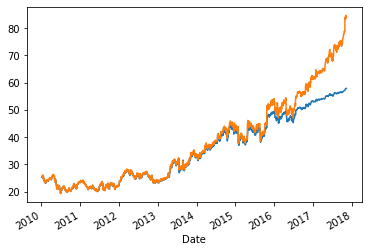

In [ ]:
# Inverse the Standard Scaler transformation
inv_pred = (y_pred*si + mu).ravel()

# Create a Pandas Series to plot the results
pd.Series(inv_pred, 
          index= msft_test[win_length:].index).plot(figsize=(15,8), label='Predictions')

# Plot the original data
msft_test[win_length:].plot(figsize=(15,8), label='Original Data')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((inv_pred.ravel() - y_test.ravel())**2))
print(f"RMSE : {rmse:.2f}")

# Bonus : Final Exercise

Compare four models on the lynx Time Series (you can find it [here](https://alkaline-ml.com/pmdarima/_modules/pmdarima/datasets/lynx.html)):


*   Exponential Smoothing
*   (S)ARIMA(X)
*   Machine Learning Model (LGBM)
*   Deep Learning Model (LSTM)

**1.Keep the last 25% of the Time Series for testing and use the remainder to train and validate.**<br>
**2.Try to optimize these models as much as possible.**<br>
**3.Find the best model.**